# The Transformer Architecture

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Positionwise Feed-Forward Networks

In [2]:
class PositionWiseFFN(nn.Module):  
    """The positionwise feed-forward network."""
    
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        # ffn_num_hiddens: 隐藏层的神经元数量（通常比输入维度大）
        # ffn_num_outputs: 输出层的神经元数量（通常等于输入维度）
        
        super().__init__()
        
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        # 第一个全连接层（线性变换层）
        # LazyLinear会在第一次前向传播时自动推断输入维度
        # 将输入维度映射到ffn_num_hiddens维度（升维操作）
        
        self.relu = nn.ReLU()
        # ReLU激活函数，用于增加非线性性
        # ReLU(x) = max(0, x)，负值变为0，正值保持不变
        
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
        # 第二个全连接层
        # 将隐藏层维度映射回输出维度（降维操作）
        # 通常ffn_num_outputs等于原始输入维度

    def forward(self, X):
        # 前向传播函数，定义数据流向
        # X: 输入张量，形状通常为(batch_size, seq_len, d_model)
        
        return self.dense2(self.relu(self.dense1(X)))
        # 数据流：X → dense1 → relu → dense2 → 输出
        # 这实现了：输入 → 升维 → 激活 → 降维 → 输出

```
nn.LazyLinear的权重和偏置都是随机初始化的，这就是为什么看到的输出不是全1，而是看似"随机"的数值
nn.Linear和nn.LazyLinear的对比：
输入维度> nn.Linear创建时必须指定；nn.LazyLinear第一次使用时自动推断
权重创建时>nn.Linear机立即创建;nn.LazyLinear延迟到第一次使用
使用场景>nn.Linear知道输入维度;nn.LazyLinear不确定输入维度
self.dense1 = nn.Linear(input_dim, hidden_dim)    # 必须指定input_dim
self.dense1 = nn.LazyLinear(hidden_dim)           # 不需要指定input_dim

In [3]:
ffn = PositionWiseFFN(4, 8)

ffn.eval()
# 将模型设置为评估模式

ffn(torch.ones((2, 3, 4)))[0]
# 使用形状为(2, 3, 4)的全1张量作为输入测试网络
# 2: batch_size（批次大小）
# 3: seq_len（序列长度）  
# 4: 输入特征维度
# [0]表示只取第一个样本的输出结果

tensor([[-0.2401, -0.2501, -0.3842,  0.0126,  0.0306, -0.2868,  0.1998,  0.1043],
        [-0.2401, -0.2501, -0.3842,  0.0126,  0.0306, -0.2868,  0.1998,  0.1043],
        [-0.2401, -0.2501, -0.3842,  0.0126,  0.0306, -0.2868,  0.1998,  0.1043]],
       grad_fn=<SelectBackward0>)

## Residual Connection and Layer Normalization

In [4]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

```
总结：
LayerNorm: 对特征维度归一化，稳定训练
残差连接: 帮助深层网络训练，防止梯度消失
AddNorm: 将两者结合，是Transformer的核心构建块
Dropout: 防止过拟合，提高模型泛化能力
这些组件共同构成了现代Transformer架构的基础

## Encoder

```
输入X → 多头自注意力 → Add&Norm1 → 前馈网络 → Add&Norm2 → 输出
  ↓           ↑                ↓           ↑
  └─────残差连接─────────────────└─────残差连接──────┘

```
# 输入处理流程：
原始输入 [2, 100] (token IDs)
    ↓
词嵌入 [2, 100, 24]
    ↓  
缩放 (* √24)
    ↓
位置编码 [2, 100, 24]
    ↓
编码器块1: 自注意力 + FFN + 残差连接 [2, 100, 24]
    ↓
编码器块2: 自注意力 + FFN + 残差连接 [2, 100, 24]
    ↓
最终输出 [2, 100, 24] (上下文感知的表示)

In [7]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    # 单个Transformer编码器块，是编码器的基本组成单元
    
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        # num_hiddens: 模型的隐藏维度（d_model），如512
        # ffn_num_hiddens: 前馈网络的隐藏层维度，通常是num_hiddens的4倍，如2048
        # num_heads: 多头注意力的头数，如8
        # use_bias: 是否在注意力计算中使用偏置
        
        super().__init__()
        
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        # 位置式前馈网络：num_hiddens → ffn_num_hiddens → num_hiddens
        
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        # 第二个Add&Norm层：用于前馈网络的残差连接和层归一化

    def forward(self, X, valid_lens):
        # valid_lens: 有效长度，用于掩码padding的token
        
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [10]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)  # ← 这里！词嵌入层
        #                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        #                创建词嵌入层：vocab_size个词 → num_hiddens维向量
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
         # 词嵌入 + 缩放 + 位置编码，全部在这一行
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        #                     ^^^^^^^^^^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^
        #                     1.词嵌入转换      2.缩放（放大）
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

```
词嵌入：
# 训练后的词嵌入会学到语义关系
# 相似的词会有相似的向量

# 例如（简化表示）：
embedding_dict = {
    "国王": [0.8, 0.2, 0.1, 0.9],
    "皇后": [0.7, 0.8, 0.1, 0.8], 
    "男人": [0.9, 0.1, 0.5, 0.3],
    "女人": [0.8, 0.9, 0.5, 0.2]
}

# 著名的类比关系：国王 - 男人 + 女人 ≈ 皇后

```
缩放的作用：
        # 想象你在做沙拉
        salad_ingredients = {
            "蔬菜": 1,      # 词嵌入（重要的营养）
            "调料": 1       # 位置编码（增味但不能太多）
        }
        
        # 不缩放：调料太重了！
        print("不缩放的沙拉:", salad_ingredients)  # 蔬菜1份，调料1份 - 太咸了！
        
        # 缩放：增加蔬菜的分量
        scaled_salad = {
            "蔬菜": 1 * 22.6,  # 词嵌入放大
            "调料": 1          # 位置编码保持不变  
        }
        print("缩放后的沙拉:", scaled_salad)  # 蔬菜22.6份，调料1份 - 均衡了！
--------------------------------------------------------------------------
# 最终效果
原始词嵌入: [0.1, -0.2, 0.3] (语义信息，但数值小)
位置编码:   [0.5, -0.8, 0.2] (位置信息，数值相对大)
直接相加:   [0.6, -1.0, 0.5] (位置编码占主导 ❌)

缩放词嵌入: [2.3, -4.5, 6.8] (语义信息被放大 ✅)
位置编码:   [0.5, -0.8, 0.2] (位置信息保持不变)  
缩放后相加: [2.8, -5.3, 7.0] (词嵌入占主导 ✅)

## Decoder

In [12]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [13]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [14]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## Training

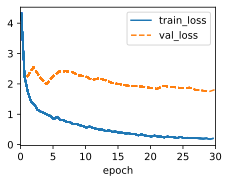

In [15]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

测试训练好的模型

In [16]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


获取注意力权重用于可视化

In [17]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

可视化编码器的自注意力

```
图1：编码器自注意力（英语内部的关系）
这个图回答：英语句子内部，词与词之间有什么关系？

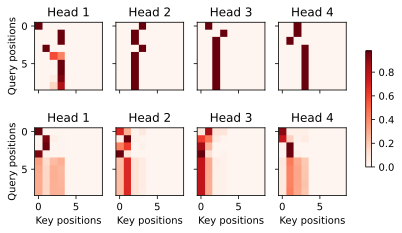

In [18]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(),  # 将数据移到CPU进行可视化
    xlabel='Key positions',       # X轴标签：被关注的位置
    ylabel='Query positions',     # Y轴标签：查询的位置  
    titles=['Head %d' % i for i in range(1, 5)],  # 4个注意力头的标题
    figsize=(7, 3.5)
)

In [20]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

可视化解码器的自注意力（掩码注意力）

```
解码器自注意力（法语内部的关系）
这个图回答：生成法语时，新词如何依赖之前生成的词？

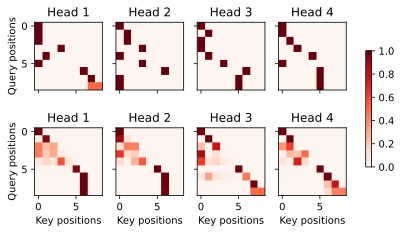

In [21]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

可视化编码器-解码器交叉注意力

```
图3：编码器-解码器交叉注意力（英语-法语对齐关系）
这个图回答：翻译时，法语词对应英语的哪些词？

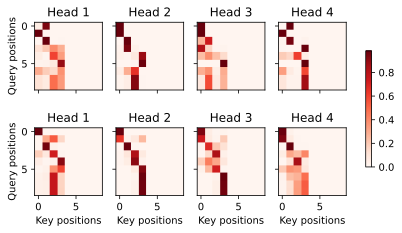

In [22]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))